<a href="https://colab.research.google.com/github/omartru10/deteccion-del-abc/blob/main/entrenamiento_tipo2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import os, os.path
import random
import cv2
import glob
import keras
import matplotlib
import matplotlib.pyplot as plt
#import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA

import pandas as pd
import numpy as np 

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
# directorio donde se almacenan las imágenes
DIR = "/content/drive/MyDrive/datasets/Fotos/Entrenamiento"#"/content/drive/MyDrive/Fotos/Entreno"

def dataset_stats():
    # Esta es una matriz con las letras disponibles.
    # Si agrega otro animal más tarde, necesitará estructurar sus imágenes de la misma manera
    # y agrega su letra a esta matriz
    datos = ['A', 'E', 'I','O','U']#['A', 'B', 'C','D','E']
    # stats sera el diccionario donde almacenaremos las estadísticas
    stats = []
    for pokemon in datos:
        # obtenemos una lista de subdirectorios que comienzan con este caracter
        directory_list = sorted(glob.glob("{}/[{}]*".format(DIR, pokemon)))
        
        for sub_directory in directory_list:
            file_names = [file for file in os.listdir(sub_directory)]
            file_count = len(file_names)
            sub_directory_name = os.path.basename(sub_directory)
            stats.append({  "Code": sub_directory_name, #"Code": sub_directory_name[:sub_directory_name.find('-')],
                            "Image count": file_count, 
                            "Folder name": os.path.basename(sub_directory),
                            "File names": file_names})
    
    df = pd.DataFrame(stats)
    
    return df

In [49]:
dataset = dataset_stats().set_index("Code")
dataset[["Folder name", "Image count"]]

,Folder name,Image count
Code,,
A,A,300
E,E,300
I,I,300
O,O,300
U,U,300


In [50]:
dataset

,Image count,Folder name,File names
Code,,,
A,300,A,"[Mano_117.jpg, Mano_118.jpg, Mano_119.jpg, Man..."
E,300,E,"[Mano_0.jpg, Mano_125.jpg, Mano_121.jpg, Mano_..."
I,300,I,"[Mano_104.jpg, Mano_105.jpg, Mano_103.jpg, Man..."
O,300,O,"[Mano_115.jpg, Mano_114.jpg, Mano_113.jpg, Man..."
U,300,U,"[Mano_107.jpg, Mano_106.jpg, Mano_103.jpg, Man..."


In [51]:
# La función devuelve un conjunto de imágenes cuyos nombres de archivo comienzan con el conjunto de caracteres dado
# después de cambiar su tamaño a 224 x 224
def load_images(codes):
    # Definimos matrices vacías donde almacenaremos nuestras imágenes y etiquetas
    images = []
    labels = []
    for i,code in enumerate(codes):
        # obtenemos el nombre de la carpeta para este código
        folder_name = dataset.loc[code]["Folder name"]
        for file in dataset.loc[code]["File names"]:                 
            # construimos la ruta del arichivo
            file_path = os.path.join(DIR, folder_name, file)
            # Leemos la imagen
            image = cv2.imread(file_path) 
            # Cambiamos el tamaño a 224 x 224
            image = cv2.resize(image, (224,224))           
            # Convertimos de BGR a RGB para que podamos trazarlos más tarde (porque openCV lee las imágenes como BGR)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            # Ahora lo agregamos a nuestra matriz
            images.append(image)
            labels.append(i)
    return images, labels

In [53]:
codes =['A', 'E', 'I','O','U']# ["A", "B", "C","D","E"]
images, labels = load_images(codes)

In [58]:
def show_random_images(images, labels, number_of_images_to_show=3):
    for code in list(set(labels)):
        indicies = [i for i, label in enumerate(labels) if label == code]
        random_indicies = [random.choice(indicies) for i in range(number_of_images_to_show)]
        figure, axis = plt.subplots(1, number_of_images_to_show)
        print("{} random images for code {}".format(number_of_images_to_show, codes[code]))
        for image in range(number_of_images_to_show):
            axis[image].imshow(images[random_indicies[image]])
        plt.show()

3 random images for code A


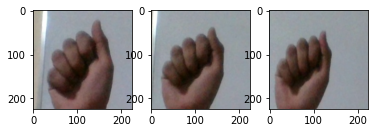

3 random images for code E


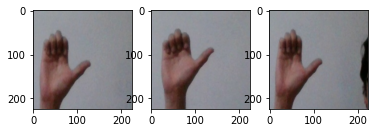

3 random images for code I


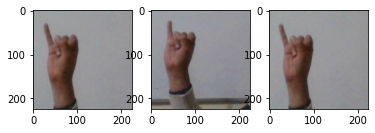

3 random images for code O


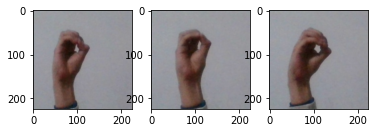

3 random images for code U


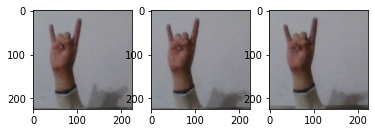

In [59]:
show_random_images(images, labels)

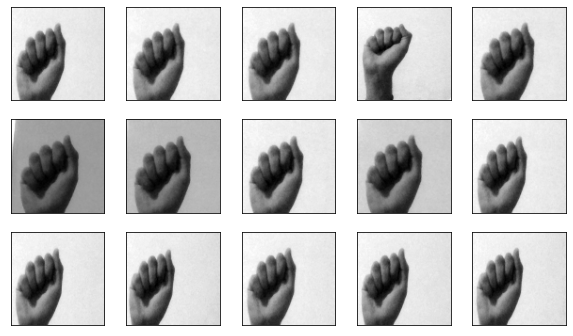

In [60]:

plt.figure(figsize=(10,10))

TAMANO_IMG=100

for i in range(0,15):
  imagen = images[i];
  imagen = cv2.resize(imagen, (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  plt.subplot(5, 5, i+1)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(imagen, cmap='gray')

In [70]:
#Variable que contendra todos los pares de los datos (imagen y etiqueta) ya modificados (blanco y negro, 100x100)
datos_entrenamiento = []

for i, (imagen) in enumerate(images): #Todos los datos
  imagen = cv2.resize(imagen, (TAMANO_IMG, TAMANO_IMG))
  imagen = cv2.cvtColor(imagen, cv2.COLOR_BGR2GRAY)
  imagen = imagen.reshape(TAMANO_IMG, TAMANO_IMG, 1) #Cambiar tamano a 100,100,1
  datos_entrenamiento.append([imagen, labels[i]])

In [ ]:
#Ver los datos del primer indice
datos_entrenamiento[0]

In [72]:
#Ver cuantos datos tengo en la variable
len(datos_entrenamiento)

1500

In [64]:
#Preparar mis variables X (entradas) y y (etiquetas) separadas

X = [] #imagenes de entrada (pixeles)
y = [] #etiquetas (perro o gato)

for imagen, etiqueta in datos_entrenamiento:
  X.append(imagen)
  y.append(etiqueta)

In [65]:
X

[array([[[165],
         [167],
         [165],
         ...,
         [151],
         [149],
         [147]],
 
        [[168],
         [169],
         [165],
         ...,
         [150],
         [151],
         [148]],
 
        [[168],
         [168],
         [166],
         ...,
         [150],
         [151],
         [149]],
 
        ...,
 
        [[160],
         [160],
         [160],
         ...,
         [151],
         [151],
         [152]],
 
        [[159],
         [160],
         [158],
         ...,
         [150],
         [149],
         [151]],
 
        [[160],
         [158],
         [158],
         ...,
         [152],
         [149],
         [148]]], dtype=uint8), array([[[164],
         [165],
         [162],
         ...,
         [151],
         [153],
         [154]],
 
        [[165],
         [166],
         [166],
         ...,
         [155],
         [157],
         [156]],
 
        [[165],
         [163],
         [164],
         ...,
       

In [66]:
#Normalizar los datos de las X (imagenes). Se pasan a numero flotante y dividen entre 255 para quedar de 0-1 en lugar de 0-255
import numpy as np

X = np.array(X).astype(float) / 255

In [67]:
X

array([[[[0.64705882],
         [0.65490196],
         [0.64705882],
         ...,
         [0.59215686],
         [0.58431373],
         [0.57647059]],

        [[0.65882353],
         [0.6627451 ],
         [0.64705882],
         ...,
         [0.58823529],
         [0.59215686],
         [0.58039216]],

        [[0.65882353],
         [0.65882353],
         [0.65098039],
         ...,
         [0.58823529],
         [0.59215686],
         [0.58431373]],

        ...,

        [[0.62745098],
         [0.62745098],
         [0.62745098],
         ...,
         [0.59215686],
         [0.59215686],
         [0.59607843]],

        [[0.62352941],
         [0.62745098],
         [0.61960784],
         ...,
         [0.58823529],
         [0.58431373],
         [0.59215686]],

        [[0.62745098],
         [0.61960784],
         [0.61960784],
         ...,
         [0.59607843],
         [0.58431373],
         [0.58039216]]],


       [[[0.64313725],
         [0.64705882],
         [0.63

In [68]:
#Convertir etiquetas en arreglo simple
y = np.array(y)

In [73]:
len(y)

1500

In [74]:
X.shape

(1500, 100, 100, 1)

In [75]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras  import datasets, layers,models

In [76]:
#Crear los modelos iniciales
#Usan sigmoid como salida (en lugar de softmax) para mostrar como podria funcionar con dicha funcion de activacion.
#Sigmoid regresa siempre datos entre 0 y 1. Realizamos el entrenamiento para al final considerar que si la respuesta se
#acerca a 0, es un gato, y si se acerca a 1, es un perro.

modeloDenso = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(100, 100, 1)),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(150, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

modeloCNN = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

modeloCNN2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(100, 100, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2, 2),

  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(250, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [77]:
#Compilar modelos. Usar categorical_crossentropy  ya  que tenemos mas de 2 opciones (perro o gato)
modeloDenso.compile(optimizer='adam',
                    loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

modeloCNN.compile(optimizer='adam',
                    loss =tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                    metrics=['accuracy'])

modeloCNN2.compile(optimizer='adam',
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

In [78]:
from tensorflow.keras.callbacks import TensorBoard

In [90]:
#La variable de tensorboard se envia en el arreglo de "callbacks" (hay otros tipos de callbacks soportados)
#En este caso guarda datos en la carpeta indicada en cada epoca, de manera que despues
#Tensorboard los lee para hacer graficas
tensorboardDenso = TensorBoard(log_dir='logs/denso')
modeloDenso.fit(X, y, batch_size=32,
                validation_split=0.15,
                epochs=100,
                callbacks=[tensorboardDenso])

Epoch 1/100
40/40 [==============================] - 1s 19ms/step - loss: 5.3496e-05 - accuracy: 1.0000 - val_loss: 1.4841 - val_accuracy: 0.6933
Epoch 2/100
40/40 [==============================] - 1s 20ms/step - loss: 5.2035e-05 - accuracy: 1.0000 - val_loss: 1.6278 - val_accuracy: 0.6889
Epoch 3/100
40/40 [==============================] - 1s 21ms/step - loss: 4.9749e-05 - accuracy: 1.0000 - val_loss: 1.6696 - val_accuracy: 0.6889
Epoch 4/100
40/40 [==============================] - 1s 21ms/step - loss: 4.7912e-05 - accuracy: 1.0000 - val_loss: 1.7720 - val_accuracy: 0.6844
Epoch 5/100
40/40 [==============================] - 1s 21ms/step - loss: 4.7340e-05 - accuracy: 1.0000 - val_loss: 1.8257 - val_accuracy: 0.6800
Epoch 6/100
40/40 [==============================] - 1s 21ms/step - loss: 4.5027e-05 - accuracy: 1.0000 - val_loss: 1.7598 - val_accuracy: 0.6844
Epoch 7/100
40/40 [==============================] - 1s 21ms/step - loss: 4.6159e-05 - accuracy: 1.0000 - val_loss: 1.7919 -

In [ ]:
#Cargar la extension de tensorboard de colab
%load_ext tensorboard

In [ ]:
#Ejecutar tensorboard e indicarle que lea la carpeta "logs"
%tensorboard --logdir logs

In [ ]:
tensorboardCNN = TensorBoard(log_dir='logs/cnn')
modeloCNN.fit(X, y, batch_size=32,
                validation_split=0.15,
                epochs=100,
                callbacks=[tensorboardCNN])

Epoch 1/100
40/40 [==============================] - ETA: 0s - loss: 0.6134 - accuracy: 0.8376

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


40/40 [==============================] - 23s 567ms/step - loss: 0.6134 - accuracy: 0.8376 - val_loss: 0.2293 - val_accuracy: 0.9600
Epoch 2/100
40/40 [==============================] - 22s 561ms/step - loss: 0.0123 - accuracy: 0.9969 - val_loss: 0.1187 - val_accuracy: 0.9556
Epoch 3/100
40/40 [==============================] - 23s 571ms/step - loss: 3.6571e-04 - accuracy: 1.0000 - val_loss: 0.0967 - val_accuracy: 0.9600
Epoch 4/100
40/40 [==============================] - 23s 578ms/step - loss: 1.6390e-04 - accuracy: 1.0000 - val_loss: 0.0923 - val_accuracy: 0.9644
Epoch 5/100
40/40 [==============================] - 23s 570ms/step - loss: 9.4804e-05 - accuracy: 1.0000 - val_loss: 0.0910 - val_accuracy: 0.9600
Epoch 6/100
40/40 [==============================] - 22s 558ms/step - loss: 5.9935e-05 - accuracy: 1.0000 - val_loss: 0.0836 - val_accuracy: 0.9644
Epoch 7/100
40/40 [==============================] - 23s 566ms/step - loss: 3.5941e-05 - accuracy: 1.0000 - val_loss: 0.0834 - val_a